# 第14回 ベイズ推論その2: ベイズ推定の応用

いつものように右上の「Remix」ボタンを押して自分用の複製を作成すれば、各セルを「Shift+Enter」で実行しながら読むことができます

編集を行なった後は、Windowsでは「Ctrl+s」、Macでは「Cmd+s」で保存することができます

最初に必要なパッケージを読み込みます

In [1]:
using LinearAlgebra: inv, logdet, I, diag
using Plots

# ベイズ線形回帰

In [1]:
# Xの多項式の基底関数
function polynomial_basis(x, M) # Mは次数
    N = length(x) # Nはデータ数
    X = zeros(Float64, N, M)
    for m = 1:M
        X[:, m] = x.^m
    end
    return X
end

polynomial_basis

In [1]:
# テストデータの作成
N = 30
#x = range(0.0, stop=1.0, length=N)
x = 2.0.*(rand(N).-0.5)
x = sort(x)
sigma2_y = 0.01
X = polynomial_basis(x, 3)
w_truth = [0.0, 0.0, 1.0]
Y = X * w_truth .+ sqrt(sigma2_y) * randn(N);

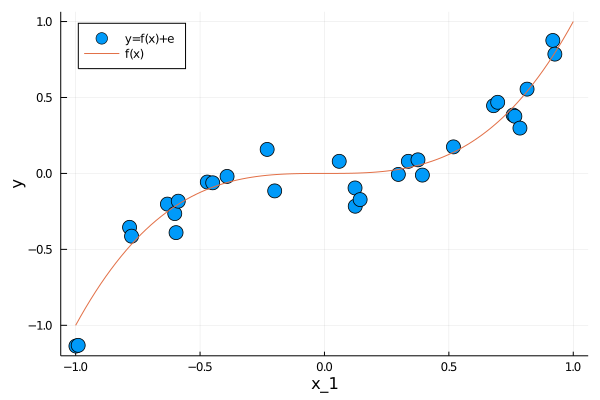

In [1]:
# テストデータのプロット
x_range = range(-1, stop=1, length=100)
scatter(x, Y, xlabel="x_1", ylabel="y", ms=8, label="y=f(x)+e")
plot!(x_range, x_range.^3, label="f(x)", legend=:topleft)

In [1]:
# ベイズ推定により、予測分布とエビデンスを計算する関数を定義する
function bayes_inference(x, Y, M, sigma2_y, sigma2_w, x_range)
    X = polynomial_basis(x, M)
    N = length(x)
    X_t = X'
    
    # posterior
    sigma2_w_new = inv(X_t*inv(sigma2_y*I(N))*X_t' + inv(sigma2_w * I(M)))
    mu_w_new = sigma2_w_new * (X_t * inv(sigma2_y * I(N)) * Y)

    # predictive
    X_range = polynomial_basis(x_range, M)
    X_range_t = X_range'
    Y_prediction = (mu_w_new' * X_range_t)
    sigma2_y_prediction = sigma2_y .+ diag(X_range_t' * sigma2_w_new * X_range_t)
    
    # evidence
    evidence = -0.5* (sum(Y) * inv(sigma2_y) + N*log.(sigma2_y) + N*log.(2*pi)
         + logdet(sigma2_w) - (mu_w_new'*inv(sigma2_w_new)*mu_w_new)[1] - logdet(sigma2_w_new))

    return Y_prediction[:], sqrt.(sigma2_y_prediction[:]), evidence
  end

bayes_inference

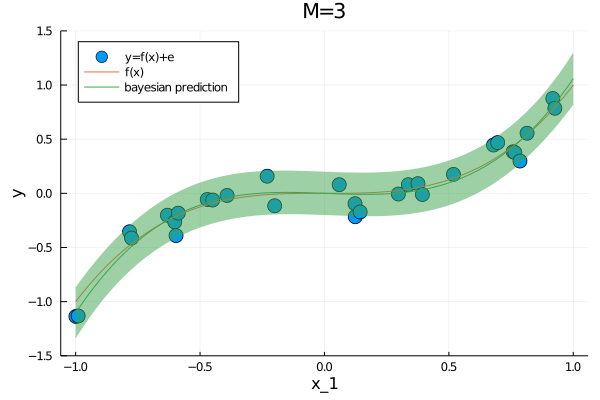

In [1]:
# 予測分布のプロット
M=3 #多項式の次数
x_range = range(-1.0, stop=1.0, length=200)
sigma2_w = 1.0
bayes = bayes_inference(x, Y, M, sigma2_y, sigma2_w, x_range)
scatter(x, Y, xlabel="x_1", ylabel="y", ms=8, label="y=f(x)+e")
plot!(x_range, x_range.^3, label="f(x)", locatoin=4)
plot!(x_range, bayes[1], ylims=(-1.5,1.5), ribbon=(2*bayes[2], 2*bayes[2]), label="bayesian prediction", legend=:topleft, title="M=$(M)")

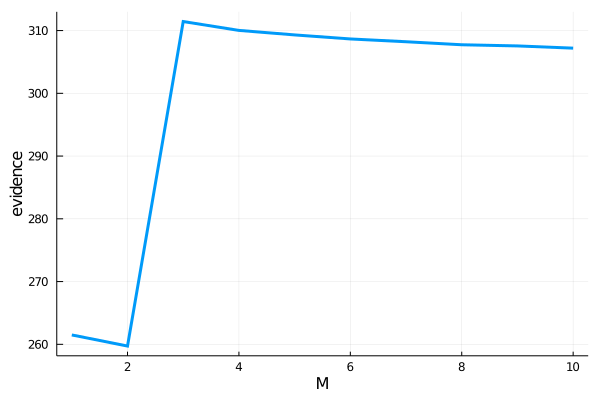

In [1]:
# エビデンスによるモデル選択
bayes_array = [bayes_inference(x, Y, m, sigma2_y, sigma2_w, x_range)  for m in 1:10]
evidence = [bayes_array[m][3] for m in 1:10]
@show evidence

plot(1:10, evidence[1:10], xlabel="M", ylabel="evidence", legend=false, line=(3))

# やってみよう

授業中に紹介したように、データ数(N)やモデルの次数(M)を変えて様々な予測分布を作ってみてください。

・Nが大きくなるとともに予測分布が(少し)狭まること

・Mが大きいときに表現力が過剰過ぎて分布が拡がること

を確認してください。